# OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어

# 스페인어  간판  번역을  위한  서비스
- 스페인어가 쓰여있는 이미지를 촬영하면 그 이미지에 있는 스페인어를 인식하여 번역을 해주는 서비스
- 스페인어를 인식하는 역할을 수행

# 이미지 불러오기

In [18]:
import os
import matplotlib.pyplot as plt
import cv2

In [19]:
data_path = os.getenv('HOME')+ '/aiffel/ocr_python/test_image'
data_path

'/aiffel/aiffel/ocr_python/test_image'

In [20]:
file_list = os.listdir(data_path)
file_path = [data_path+'/'+name for name in file_list]
file_path = sorted(file_path)
file_path

['/aiffel/aiffel/ocr_python/test_image/test_01.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_02.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_03.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_04.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_05.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_06.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_07.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_08.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_09.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test_10.jpg']

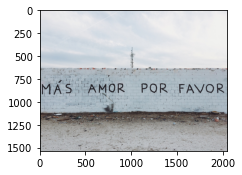

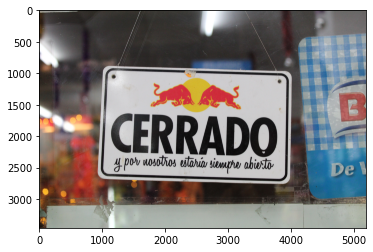

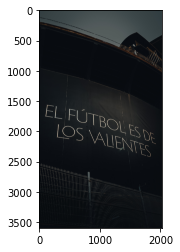

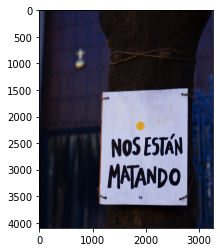

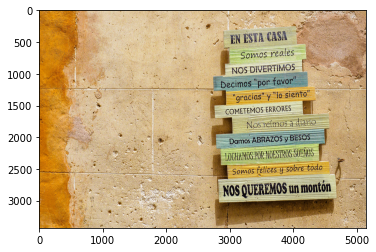

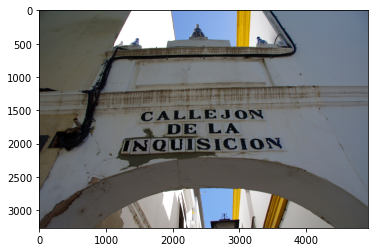

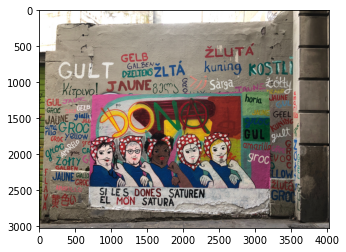

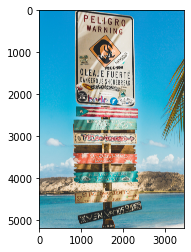

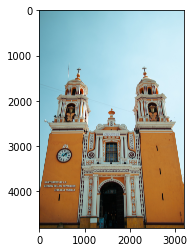

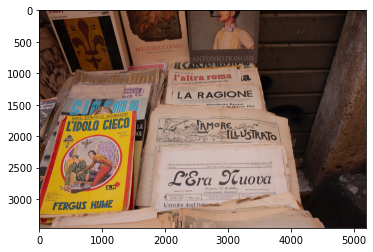

In [23]:
rows = 5
cols = 2
fig = plt.figure(figsize=(30,15))
for idx, path in enumerate(file_path, 1):
    ax = fig.add_subplot(rows, cols, idx)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img)
    
    plt.show()

텍스트의 모양과 크기, 배치, 노이즈(그림자)가 다양하게 적용된 이미지 10장을 준비했다.

# keras-ocr

- **텐서플로우의 케라스 API**를 기반으로 이미지 속 문자를 읽는 **End-to-End OCR**을 할 수 있게 해줌
- 검출 모델 : **CRAFT(Character Region Awareness for Text Detection)** 사용
- 인식 모델 : **CRNN**

In [10]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


### recognize()

검출기와 인식기를 두고, 

검출기로 바운딩 박스(bounding box, 문자가 있는 영역을 표시한 정보)를 검출한 뒤,

인식기가 각 박스로부터 문자를 인식하는 과정을 거치도록 함.

In [24]:
images = [keras_ocr.tools.read(path) for path in file_path]
prediction_groups = [pipeline.recognize({path}) for path in file_path]

### Plot the predictions

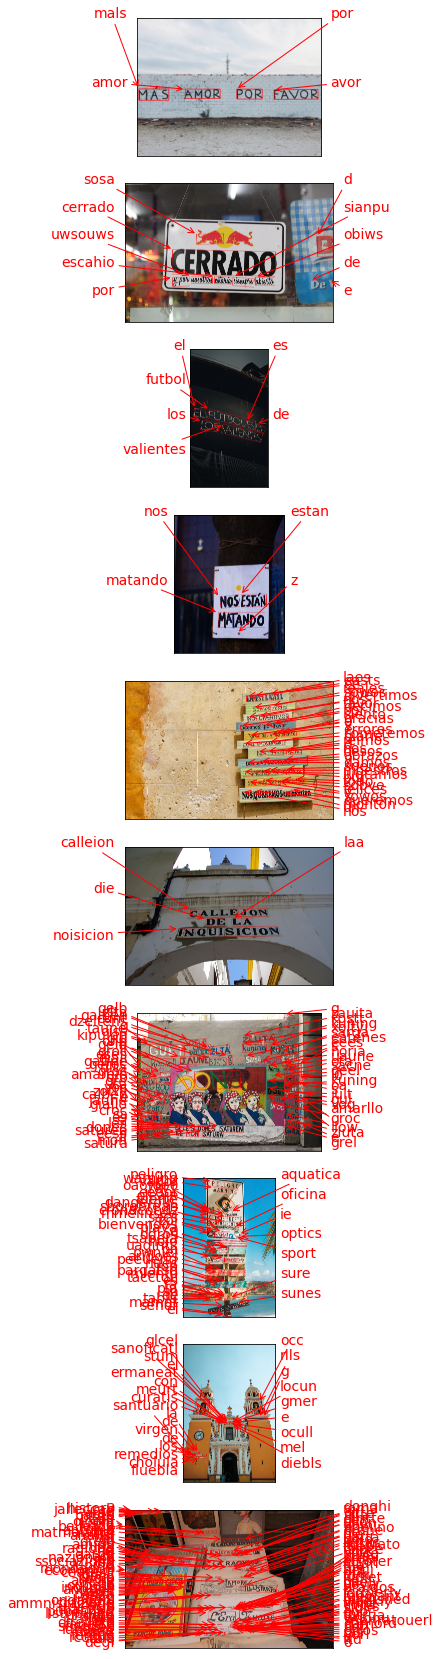

In [25]:
fig, axs = plt.subplots(nrows=len(images), figsize=(30, 30))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

# 테서랙트 (Tesseract)

- 구글에서 후원하는 OCR 오픈소스 라이브러리

- 현재는 버전 4와 Tesseract.js등으로 확장되는 등 많은 곳에서 사용

- 버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116 개 국어를 지원

<테서렉트 설치>

**sudo apt install tesseract-ocr**

**sudo apt install libtesseract-dev**

<테서랙트 파이썬 wrapper 설치>

**Pytesseract**는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리(wrapper library)

파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해줌

**pip list | grep pytesseract**

- cloud shell 에서 **sudo apt install tesseract-ocr-spa** 코드로 스페인어 설치

https://tesseract-ocr.github.io/tessdoc/Data-Files-in-different-versions.html

## 테서랙트로 문자 검출하고 이미지 자르기 (detection)

In [29]:
import pytesseract
from PIL import Image
from pytesseract import Output

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path, output_path='./output', lang='kor'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    
    recognized_data = pytesseract.image_to_data(
        image, lang=lang,
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
        
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
#             print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
        
    return cropped_image_path_list
    
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract'
    
    
tesseract_result_path = []
for path in file_path:
    image_path_list = crop_word_regions(path, work_dir)
    tesseract_result_path.extend(image_path_list)

## 테서랙트로 잘린 이미지에서 단어 인식
-  검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나오는 **image_to_string()**를 사용

In [31]:
def recognize_images(cropped_image_path_list, lang='spa'):
    custom_oem_psm_config = r' --oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang=lang,
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print('Done')
#     return recognized_data


recognize_images(tesseract_result_path)

e

>,

AM MN)

Y

-

X

A

Arno ll

MiS

o


z

e

e

e

>,

AM MN)

Y

-

X

A

Arno ll

MiS

o


z

e

TW

$

er

rut í

e

¿a

Ty

atisi

| | a > ; eli ! | P |

"MN


A


0

WTF

P

tra

r

o

3

€

a

T

11

diritto

ana

CENTESIM]

7

ed

and

e

e

>,

AM MN)

Y

-

X

A

Arno ll

MiS

o


z

e

TW

$

er

rut í

e

¿a

Ty

atisi

| | a > ; eli ! | P |

"MN


A


0

WTF

P

tra

r

o

3

€

a

T

11

diritto

ana

CENTESIM]

7

ed

and

distributed

rte

ed

under ¡permi!

mí

vit

Wi

»

22

AD A

L Era

dirottove

-

pe

DANFITIA

.

ITAilliaAa

y

ANNO

ET

TAS

$1.00

SAI

r RO

|

+ gaak

Ñ

y

As >


(

E A

Ln


-oma

%

">

JA

E

ALIAS

cittáa

e

>,

e

e

>,

AM MN)

Y

-

X

A

Arno ll

MiS

o


z

e

TW

$

e

>,

AM MN)

Y

-

X

A

Arno ll

MiS

o


z

e

TW

$

er

rut í

e

¿a

Ty

atis

딱 봐도 제대로 인식하지 못했다는 것을 알 수 있다.

# 테스트 시각화

In [32]:
def ocr_model_comparison(img_idx):
    print('Original image:')
    img = cv2.imread(file_path[img_idx], cv2.IMREAD_COLOR)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img)
    plt.show()
    
    print('Tesseract result:\n')
    work_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract/'+str(img_idx)
    cropped_image_path = crop_word_regions(file_path[img_idx], work_dir)
    recognize_images(cropped_image_path)
        
    print('keras-ocr result:\n')
    keras_ocr.tools.drawAnnotations(image=images[img_idx], predictions=prediction_groups[img_idx][0])

Original image:


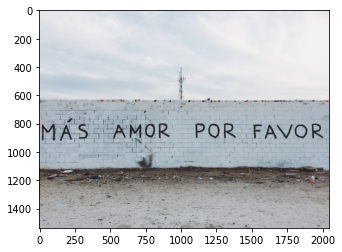

Tesseract result:

AAA a == Tagua Ps íK]O, SS -— — o —  :» ==... a mE o. o — — —” > o xx TA SAS > ÍA ARS Al) ” -—. — — o. um Co AT, — — —» > ».. =TÍZTER A — — — — — — PIE. o ——— << MS

_—jÉÁAx ==» AAA.” wm. Oo... a >» AS A o — MS TE A IIA. O. — O ——— — —  _.. ve... ao ARA

A A s A << A. "A. '> “MY

A E A SA O A PP... AMA... _  ””"r—. € — ASA E84$+<mu qQE0 q AP RRA. E .PD[t) E EOE€<«<« A A AA OOO]S7g7TO OOOO. O A AZ A —o ————=».m.nknkn._. TT ._— =—. ”—” Pp =_—_— A E A A E A E . HA TA

|

AA AAA e A AA AA A AA AAA PA A A A A A ” q E

A A A A AA a ia gg A a. ca AA A A A A A


AA E AAA A AOS As >" E "AS. A > > Pp — — > ASS .P.p. AAA ÁÓWÓ E €4á == * AAA e —— AA e e nn o TO A A /4A7A< (I¡]3])]3OSCC)35| | | |35SE3 A AAA A A A AA . - - ua dl “di nn — a

q. + a ii ¡IBEM nn — a rr "so. A A A 22... — —— —_ooo.o.o.ÑG —— ———— —— — ———_.— > — As A A A PP A AA AE A A das A a» uu «MH

-— ku —= eo ÁK o —” o_o OA QA _Á— É » -—— — ———— a A a — A o A A E ap 4 .*

A ¿ss "óáñkúóó AAA O a A A a Da

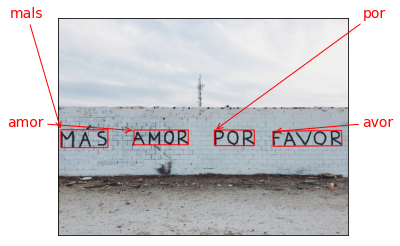

In [34]:
ocr_model_comparison(0)

Original image:


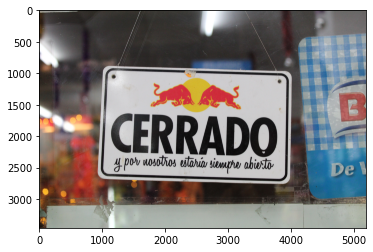

Tesseract result:

O, j Y |

Done
keras-ocr result:



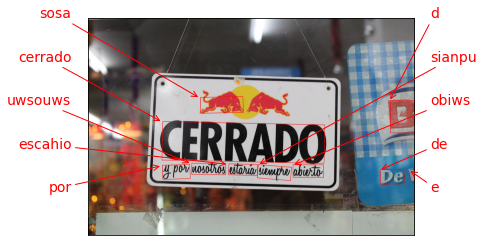

In [33]:
ocr_model_comparison(1)

Original image:


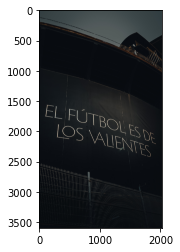

Tesseract result:

pu


ARRE TS AN



IR

¡AÑ

AA

AN

|

|

M

|

j |

A

|

:

ANA

|

|

Ml


|


'

AUNAR




s

SS O O O O O O O AAA MA AED  :

0 al A O 7 El lo ps ¡ol E 1 A Ñ 3 0 A A TO A A O O O O O O A O O a o 0 E PE

a 7

7

%





|



|

Done
keras-ocr result:



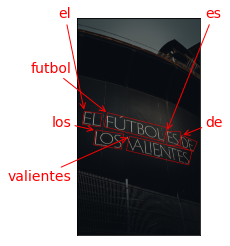

In [35]:
ocr_model_comparison(2)

Original image:


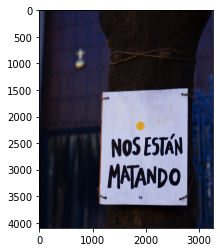

Tesseract result:

' y

Done
keras-ocr result:



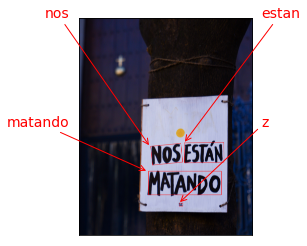

In [36]:
ocr_model_comparison(3)

Original image:


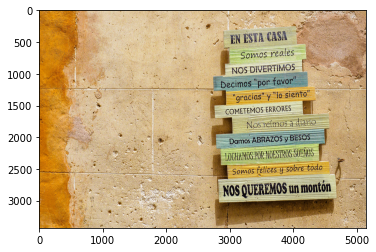

Tesseract result:

a TT

A A

A —— mm









O A A A A A O A A A A AS >

A O A

A ve o. e A O A a ón o

O TA nn Po. o an



A — ____Q»-_— A

=== == 1 IS AE 2 ==





¿QE_RSR o _———— YN


=> — o —— E > an






e nn aan ón nn AX








nn



+ — - — y


qÉ<É—<—<—_—_—_——__—————— A —=



<=

o a —=——

==

MEE PI] EA A EEtE KK A ss rr EZ Y an

e

e 5 5 5 5 5 A

e 5 5 5 5 5 A








_— 2 == A _ AA










A

AAA ss O A EemE E A A

Pa — ___-<__—_— AAA





o o —

o o o

A a Y TT O


O e rr rn IR A PP


Done
keras-ocr result:



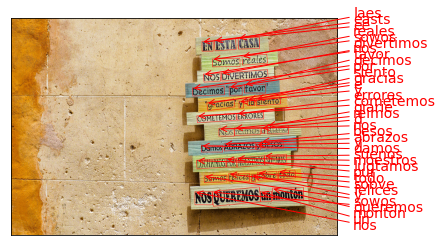

In [37]:
ocr_model_comparison(4)

Original image:


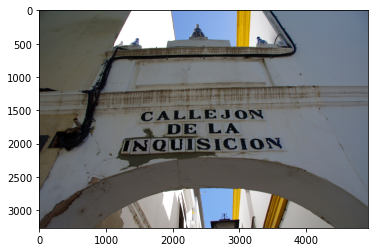

Tesseract result:

AAA

Ñ | | al [ )

Done
keras-ocr result:



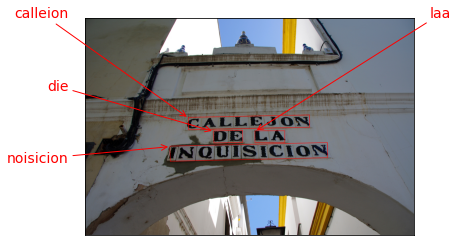

In [38]:
ocr_model_comparison(5)

Original image:


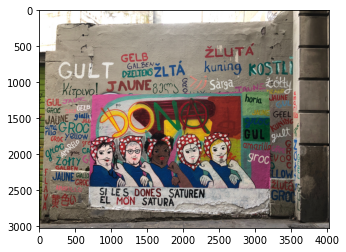

Tesseract result:


Done
keras-ocr result:



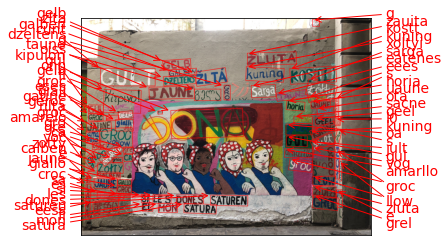

In [39]:
ocr_model_comparison(6)

Original image:


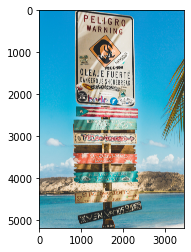

Tesseract result:


aa. A PP

A AAA —KÉAA A =P A _- _-- Ec. > => A pa

un

Y Y

q


FF


h

/

f

?

r

.

Done
keras-ocr result:



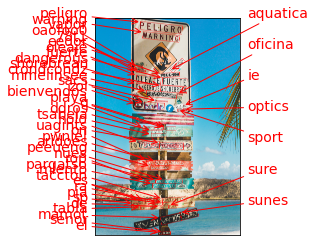

In [40]:
ocr_model_comparison(7)

Original image:


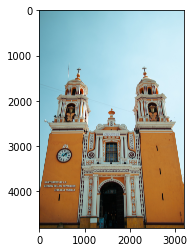

Tesseract result:

W AM UI NS NM A U

UM


A

y





| EFE Mo


añ ) en 1 i i t ] 1 E —



,l

+


Ú

+.

$

"

LAS


,

A RM A ic ci Ei, dió dl ió. 1 Ve as

E.


FLEGI,

E

AV

S AMO VIFICAY |

LOCUNN

TAME tela DC

ISTUM,UTST

SIT JIEl

MOME MM

WE UM,

Me

E ST

PE

AHM A

JE A (NT

(S0L

JJ!

4

WE

-

A

1

—-

|

COR

MEUM

181

LUMNC 115

1)

l

-

-HUS.


AS ALA APA DO

“E. A. — WO RA O O

Done
keras-ocr result:



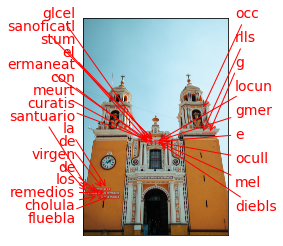

In [41]:
ocr_model_comparison(8)

Original image:


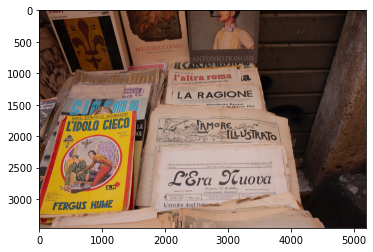

Tesseract result:

e

>,

AM MN)

Y

-

X

A

Arno ll

MiS

o


z

e

TW

$

er

rut í

e

¿a

Ty

atisi

| | a > ; eli ! | P |

"MN


A


0

WTF

P

tra

r

o

3

€

a

T

11

diritto

ana

CENTESIM]

7

ed

and

distributed

rte

ed

under ¡permi!

mí

vit

Wi

»

22

AD A

L Era

dirottove

-

pe

DANFITIA

.

ITAilliaAa

y

ANNO

ET

TAS

$1.00

SAI

r RO

|

+ gaak

Ñ

y

As >


(

E A

Ln


-oma

%

">

JA

E

ALIAS

cittáa

1148

ht

'

LAS

A


o Vi 7 ma] NY | Paltr al rom: ¡a

A

pS

E

su

q” y

.

A”

K

==

Mi


y

.

ds

mM

Xx

O

rr

«Ai

A HIM UD

5

XL

Y

"NA

Ln y

"na

L

1»

a,

A

e

>. E

X

Y»

y mr!

M3

a

MILANO,

1

E

ION

Ni

0),

LUZ

MAGGIO

A

GGIO

14)

Formerly

FAFTTA" AS

“T"Araldo,,

IT

Vi

LON TO

LALA S

y

A A

0

"

“tRBecedani

Re

e

cedant vetera,

omnia

mf


TELAS LA

, e |


S



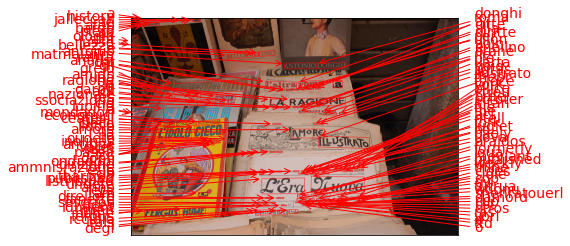

In [42]:
ocr_model_comparison(9)

# 회고

결과를 시각화해보니 뚜렷한 차이가 보인다. 

keras의 검출기가 이미지에 있는 문자를 확연히 잘 인식하고, 테서랙트는 매우 떨어지는 성능을 보인다.

하지만 이미지에 있는 문자가 많을 경우 수많은 글자가 동시에 출력되기 때문에

어떤 문자가 있는 지 알아보기 힘들다는 단점이 있다.

이를 추출하는 함수를 구현해보고자 했지만 실패했다.

어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 수행한다고 가정한다면

테서랙트보다 keras를 도입하는 것이 좋을 것이라고 주장할 수 있다.